<a href="https://colab.research.google.com/github/viyer-research/SideChannelAttacks/blob/main/TensorFlow_SCA_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Tensorflow/Machine Learning for unsupervised side-channel analysis classification

This Notebook is part of the article on using TensorFlow for unsupervised side-channel classification found [here](https://leveldown.de/blog/tensorflow-sidechannel-analysis/)

## Download and extract the samples

In [ ]:
!rm sca_train*
!wget https://leveldown.de/sca_train.tgz
!tar xzf sca_train.tgz

rm: cannot remove 'sca_train*': No such file or directory
--2022-11-12 17:16:59--  https://leveldown.de/sca_train.tgz
Resolving leveldown.de (leveldown.de)... 91.121.173.42
Connecting to leveldown.de (leveldown.de)|91.121.173.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63235071 (60M) [application/octet-stream]
Saving to: ‘sca_train.tgz’

sca_train.tgz       100%[===================>]  60.30M  11.2MB/s    in 6.1s    

2022-11-12 17:17:06 (9.87 MB/s) - ‘sca_train.tgz’ saved [63235071/63235071]



Import everything we need. We also specify that we only want to look at the first 400 samples of each training file.

In [ ]:
import matplotlib.pyplot as plt

from scipy import signal
import numpy as np
import scipy as sp
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import math

data_length = 400

## Introspecting the data

Lets look at two signals, plotted over each other to get an idea on how they look.

First, lets look at a signal of the digit 0.

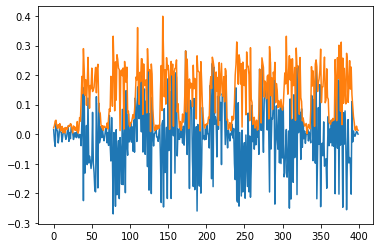

In [ ]:
data0 = np.load("try_0_1_short.npy")[:data_length]
plt.figure().set_facecolor('white')
plt.plot(data0.real)
plt.plot(np.abs(data0))
plt.show()

Lets do the same for the digit 7:

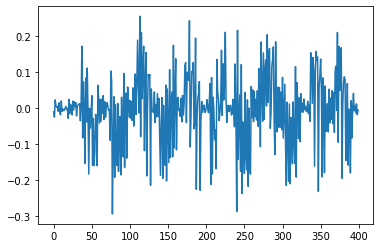

In [ ]:
data7 = np.load("try_7_1_short.npy")[:data_length]
plt.figure()
plt.plot(data7.real)
plt.show()

If we plot the two digits over each other, we get a better idea of the differences.

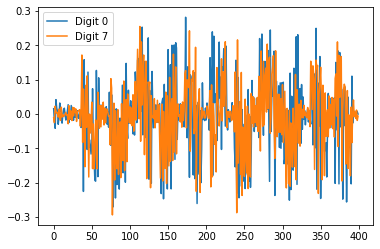

In [ ]:
plt.figure()
plt.plot(data0.real, label="Digit 0")
plt.plot(data7.real, label="Digit 7")
plt.legend()
plt.show()

As you can see, the signal is **very** noisy, making it hard to really see any differences. If we apply a bandpass filter, the differences between the two signals become much more clear.

## Bandpass filtering

We want to run a bandpass filter on our signals to make life of our neural network easier: By applying a bandpass the neural network does not have to learn to ignore the noise and instead can focus on the actual signal

In [ ]:
# Configure the bandpass for the signal

bandpass_start = 0.55
bandpass_end = 0.60
bandpass_order = 4

def apply_bandpass(s, order=bandpass_order, low=bandpass_start, high=bandpass_end):
#     butter(order, [low, high], btype='band')
    b, a = signal.butter(order, [low, high], btype='band')
    zi = signal.lfilter_zi(b, a)
    z, _ = signal.lfilter(b, a, s, zi=zi*s[0])
    return z


Lets take a look at how the bandpass filter changes our two signals:

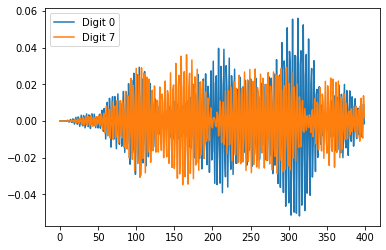

In [ ]:
#               data = np.abs(apply_bandpass(np.load(filename)[:data_length])).real
plt.figure()
plt.plot(apply_bandpass(data0).real, label="Digit 0")
plt.plot(apply_bandpass(data7).real, label="Digit 7")
plt.legend()
plt.show()

As you can see, the difference between the two digits becomes much more clear. This will make the life of our neural network much easier! You can experiment more with filtering or different representations:

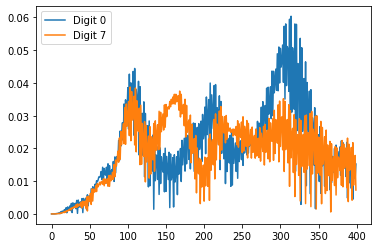

In [ ]:
plt.figure()
plt.plot(np.abs(apply_bandpass(data0)), label="Digit 0")
plt.plot()
plt.plot(np.abs(apply_bandpass(data7)).real, label="Digit 7")
plt.legend()
plt.show()

## Preprocessing pipeline

We want to ensure that the data all has the same length and is normalized between 0.0 and 1.0 - for that we use the MinMax Scaler.

We also want to shuffle our training data so that the network is trained in randomized order.

In [ ]:
# Preprocessing pipeline
scaler = MinMaxScaler()

# Copied from https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


## Loading the training and verification data

We have 50 samples per digit and 4 digits (0, 7, 8 & 9). We will split the data into two sets: The training data and the test data. The training data will be used to train and validate the training of the neural network, while the test data will only be used at the very end to see how well our trained network performs on data it has never seen.

It is very important to never use the test data during training: It will skew your results!

Our loading pipeline works like this:

- Load 400 samples from the respective file
- Apply the bandpass filter
- Take the absolute value of the bandpass
- Reshape the data from a 400 entry array into a 20x20 2D array (this makes graphing easier)
- Ensure that we have labels mapping the digit (0, 7, 8, 9) to each sample, so the network knows what digit a sample corresponds to
- Use the scaler to normalize the samples between 0.0 and 1.0
- Shuffle both the training and the test set to be in random order

In [ ]:
def load_data():
    digits = [0, 7, 8, 9]
    training_data = []
    training_labels = []
    for digit in digits:
        for i in range(1, 41):
            filename = "try_%d_%d_short.npy" % (digit, i)
            try:
              data = np.abs(apply_bandpass(np.load(filename)[:data_length])).real
            except:
              continue
            data = scaler.fit_transform(np.reshape(data, (20, 20)))
            training_data.append(data)
            training_labels.append(digit)
    training_data = np.array(training_data)
    training_labels = np.array(training_labels)
    training_data, training_labels = unison_shuffled_copies(training_data, training_labels)
    
    test_data = []
    test_labels = []
    for digit in digits:
        for i in range(41, 51):
            filename = "try_%d_%d_short.npy" % (digit, i)
            try:
              data = np.abs(apply_bandpass(np.load(filename)[:data_length])).real
            except:
              continue
            data = scaler.fit_transform(np.reshape(data, (20, 20)))
            test_data.append(data)
            test_labels.append(digit)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    test_data, test_labels = unison_shuffled_copies(test_data, test_labels)
    
    
    
    return (training_data, training_labels), (test_data, test_labels)
  
# Load the training data
(train_data, train_labels), (test_data, test_labels) = load_data()

This is how one of our loaded training samples looks when plotted in a 20x20 graph. This is the input that our network will see.

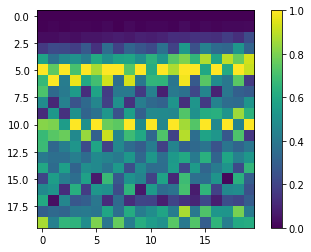

In [ ]:
plt.figure()
plt.imshow(train_data[1])
plt.colorbar()
plt.grid(False)

## Training the network

Keras is the deep learning library we use. We build a three layer network:

- A flatten layer that removes all dimensions except 1. We also specify our input shape, which is 20x20
- A 128 output layer
- A 10 output layer (that will map to our PIN digits, we have 10 possible results (though we only train on 4 in this case)

Feel free to add more layers here and experiment with the different activation functions etc.

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(20, 20)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

Next, we compile our model. For that we need to specify an optimizer, AdamOptimizer is a good general purpose choise. We also specify a loss function, more details on these can be found for example [here](https://jovianlin.io/cat-crossentropy-vs-sparse-cat-crossentropy/). We also specify the metric that is used to judge the performance of our model, in this case we simply use 'accuracy'.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lets save our current model state so we can reload it loater
model.save_weights("pre-fit.weights")

We can now train our model. This might take a while! Here, we train for 200 epochs (basically the number of times we let our network train on our dataset), and we also split our training data off into a training set and a validation set: The training set is what the network actually learns on, and the validation set is used to judge how well it performs.

In [ ]:
history = model.fit(train_data, train_labels, epochs=200, verbose=0, validation_split=0.2)

After we have trained our network, we want to take a look at how well it performs. So lets plot the accuracy and the loss of our model on both the training set and the validation set.

Loss hereby indicates how far the result of the network deviates from the actual values, so higher loss is bad.


We also plot the accuracy, where higher accuracy = better. 


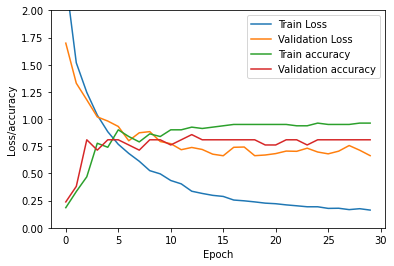

In [ ]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss/accuracy')
  plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Validation Loss')
  plt.plot(history.epoch, np.array(history.history['accuracy']),
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),
           label = 'Validation accuracy')
  plt.legend()
  plt.ylim([0, 2])

plot_history(history)



In the plot we can see that the training and validation loss at first quickly decrease, and eventually we reach a very low loss on the training data (and a very high accuracy - almost 100% - too!), however the loss on our validation data is getting worse and worse. 

This is called **overfitting**: We trained the network on our training data so often that instead of recognizing patterns, it learned to recognize our actual training data. This will make our accuracy on *real* data far worse. You want to find the sweet spot where the loss of our validation data is best. In the graph this is between 25-40.

So lets train our model again with 40 epochs!

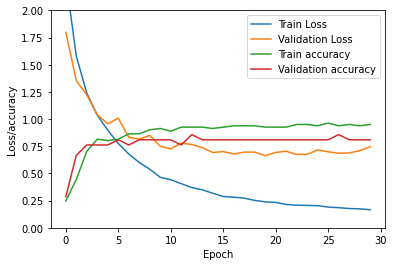

In [ ]:

# Load the weights. This is required as if we just run 'fit' again, it will continue to use the weights from our 200 epoch fit.
model.load_weights("pre-fit.weights")
history = model.fit(train_data, train_labels, epochs=30, verbose=0, validation_split=0.2)
plot_history(history)

## Testing accuracy against our test data

Lets let the model evaluate our test data, and see how well it performs!

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Accuracy on testdata:', test_acc * 100, "%")

1/1 [==============================] - 0s 28ms/step - loss: 0.1385 - accuracy: 1.0000
Accuracy on testdata: 100.0 %


## 96% accuracy! Wow!

## Plotting our results

1/1 [==============================] - 0s 80ms/step


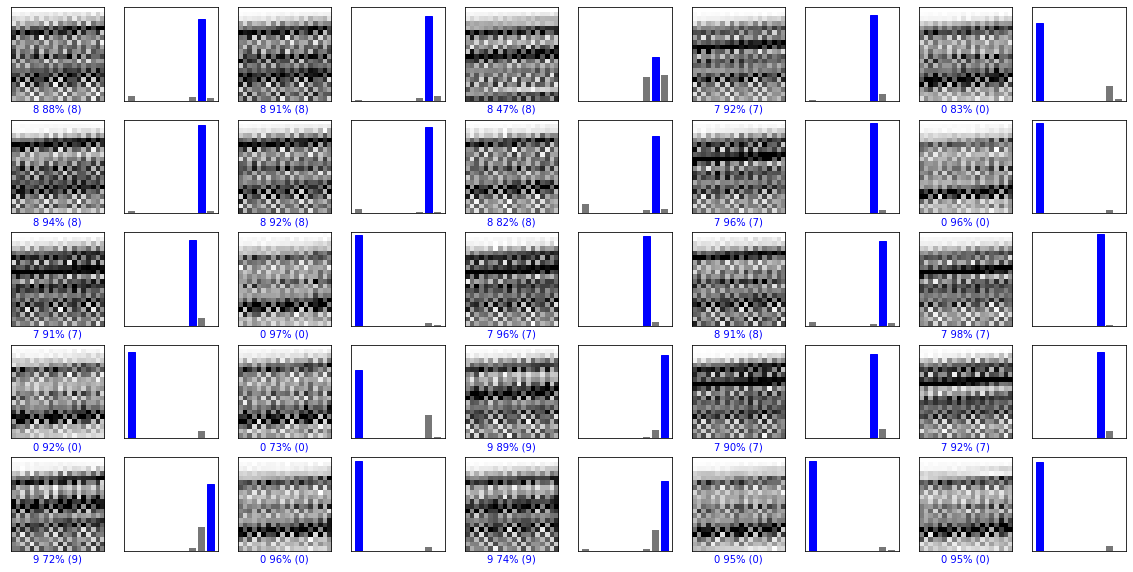

In [ ]:
predictions = model.predict(test_data)

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(str(predicted_label),
                                100*np.max(predictions_array),
                                str(true_label)),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_data)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Here we now plotted the prediction of all our test samples. The blue bar indicates the correct digit, the red bar (if shown) shows the wrong result.

The height of each bar indicates how confident the network is in a specific result.